# 🎯 DETOXIS Borrador 2 - One-vs-All Classifier

## 🚀 Enfoque Moderno: One-vs-All (OvA)

**Estrategia**:
- 🔢 **4 clasificadores binarios independientes** (uno por cada clase)
- 🎯 Cada modelo aprende: "¿Es esta clase?" vs "¿No es esta clase?"
- 🏆 Predicción final: la clase con mayor probabilidad
- ⚖️ Manejo natural del desbalance por clase
- 🔥 Optimizado para A100 con mixed precision

**Beneficios del OvA**:
- ✅ Mejor manejo de clases minoritarias (clase 3: solo 69 ejemplos)
- ✅ Permite ajustar pesos por clase independientemente
- ✅ Más robusto que multi-class directo con alto desbalance
- ✅ Ensemble natural de 4 expertos

---

## 🖥️ Setup: Google Drive + GPU

In [ ]:
# Montar Google Drive
from google.colab import drive
from sklearn.model_selection import StratifiedKFold

N_SPLITS = 5
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
drive.mount('/content/drive')

# Verificar GPU A100
!nvidia-smi

print("✅ Google Drive montado")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Wed Feb  4 19:43:31 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   42C    P0             64W /  400W |    4245MiB /  81920MiB |      0%      Default |
|          

In [ ]:
# Instalación de dependencias
!pip install -q transformers datasets accelerate scikit-learn torch matplotlib seaborn

print("✅ Dependencias instaladas")

✅ Dependencias instaladas


In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import warnings
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from datasets import Dataset
import os

warnings.filterwarnings('ignore')

# Configuración visual
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

# Verificar GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Dispositivo: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memoria: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

🚀 Dispositivo: cuda
   GPU: NVIDIA A100-SXM4-80GB
   Memoria: 79.32 GB


---
## 📂 Configuración de Rutas

**INSTRUCCIONES**:
1. Sube los archivos CSV al workspace de Colab
2. Los pesos se guardarán en Google Drive

In [ ]:
# Configuración de rutas
TRAIN_DATA_PATH = "Detoxis_train_kaggle.csv"
TEST_DATA_PATH = "Detoxis_test_kaggle.csv"
DRIVE_SAVE_PATH = "/content/drive/MyDrive/Pesos_Sota/Borrador2_OvA"

# Crear carpeta en Drive
os.makedirs(DRIVE_SAVE_PATH, exist_ok=True)

print(f"📁 Carpeta de pesos: {DRIVE_SAVE_PATH}")
print(f"✅ Rutas configuradas")

# Cargar datos
df_train = pd.read_csv(TRAIN_DATA_PATH)
df_test = pd.read_csv(TEST_DATA_PATH)

print(f"\n📊 Datos cargados:")
print(f"   Train: {len(df_train)} ejemplos")
print(f"   Test: {len(df_test)} ejemplos")
print(f"\n📋 Distribución de clases (train):")
print(df_train['label'].value_counts().sort_index())

display(df_train.head())

📁 Carpeta de pesos: /content/drive/MyDrive/Pesos_Sota/Borrador2_OvA
✅ Rutas configuradas

📊 Datos cargados:
   Train: 3463 ejemplos
   Test: 891 ejemplos

📋 Distribución de clases (train):
label
0    2316
1     809
2     269
3      69
Name: count, dtype: int64


id                                               text  label
0   0                           Pensó: Zumo para restar.      1
1   1   Como les gusta el afeitado en seco a esta gente.      1
2   2  asi me gusta, que se maten entre ellos y en al...      2
3   3  Loss mas valientes, los que mejor cortan nuest...      1
4   4                                      Costumbres...      1

In [ ]:
import pandas as pd
import re
import html
import unicodedata

def deep_clean_text(text):
    if not isinstance(text, str):
        return ""

    # 1. Unescape HTML (ej. &amp; -> &)
    text = html.unescape(text)

    # 2. Corregir Mojibake (errores de codificación comunes de la ñ y tildes)
    encoding_fixes = {
        'Ã±': 'ñ', 'Ã‘': 'Ñ', 'Ã¡': 'á', 'Ã©': 'é', 'Ã­': 'í',
        'Ã³': 'ó', 'Ãº': 'ú', 'Ã': 'Á', 'Ã‰': 'É', 'Ã': 'Í',
        'Ã“': 'Ó', 'Ãš': 'Ú', 'Â¿': '¿', 'Â¡': '¡', 'Ã¼': 'ü'
    }
    for bad, good in encoding_fixes.items():
        text = text.replace(bad, good)

    # 3. Normalización Unicode (NFKC unifica caracteres combinados)
    text = unicodedata.normalize('NFKC', text)

    # 4. Limpieza de ruido de redes sociales (URLs y menciones)
    text = re.sub(r'http\S+|www\S+|https\S+', '[URL]', text)
    text = re.sub(r'@\w+', '[USER]', text)

    # 5. Normalizar risas (ej: jajjajajaj -> jaja)
    text = re.sub(r'\b(j[aeiou])\1+\b', 'jaja', text, flags=re.IGNORECASE)

    # 6. Eliminar caracteres de control y normalizar espacios
    text = "".join(ch for ch in text if unicodedata.category(ch)[0] != "C")
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# --- Ejecución y sobreescritura de archivos ---

print("🧼 Iniciando limpieza profunda de caracteres...")

# Carga de archivos
df_train = pd.read_csv("Detoxis_train_kaggle.csv")
df_test = pd.read_csv("Detoxis_test_kaggle.csv")

# Estandarizar nombre de columna de texto (Test suele usar 'comment')
if 'comment' in df_test.columns:
    df_test = df_test.rename(columns={'comment': 'text'})

# Aplicar limpieza
df_train['text'] = df_train['text'].apply(deep_clean_text)
df_test['text'] = df_test['text'].apply(deep_clean_text)

# Eliminar filas que hayan quedado vacías en el entrenamiento
df_train = df_train[df_train['text'].str.len() > 0]

# Sobreescribir los CSV originales
df_train.to_csv("Detoxis_train_kaggle.csv", index=False)
df_test.to_csv("Detoxis_test_kaggle.csv", index=False)

print("✅ Preprocesamiento completado. Archivos CSV actualizados con éxito.")

🧼 Iniciando limpieza profunda de caracteres...
✅ Preprocesamiento completado. Archivos CSV actualizados con éxito.


---
## 📊 Análisis Exploratorio

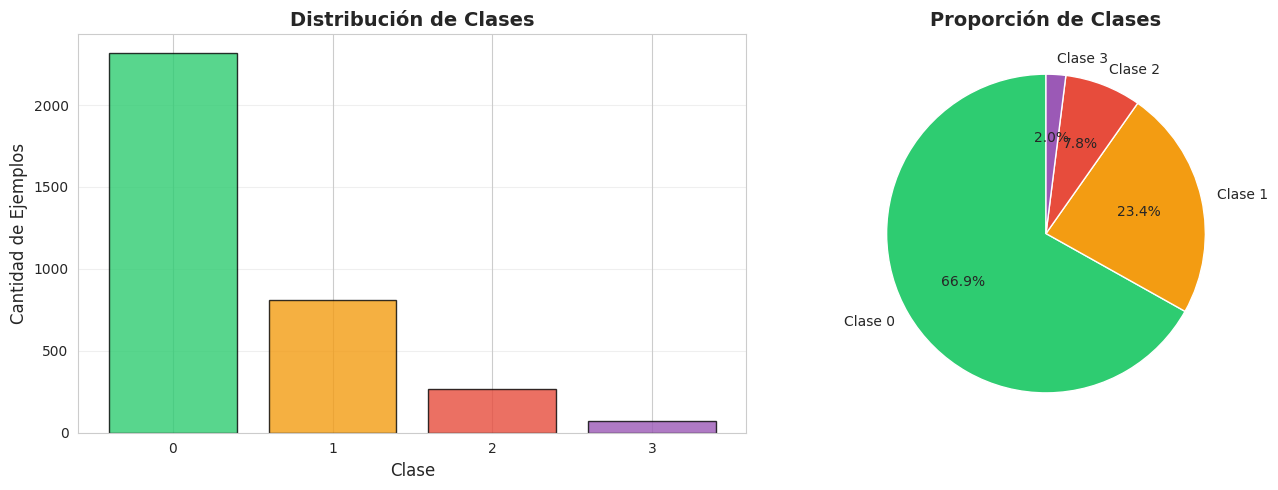


⚖️ Ratio de desbalance (respecto a clase mayoritaria):
   Clase 0: 1.00x (necesita 1.0x más peso)
   Clase 1: 2.86x (necesita 2.9x más peso)
   Clase 2: 8.61x (necesita 8.6x más peso)
   Clase 3: 33.57x (necesita 33.6x más peso)


In [ ]:
# Visualizar distribución
class_counts = df_train['label'].value_counts().sort_index()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras
colors = ['#2ecc71', '#f39c12', '#e74c3c', '#9b59b6']
axes[0].bar(class_counts.index, class_counts.values, color=colors, alpha=0.8, edgecolor='black')
axes[0].set_xlabel('Clase', fontsize=12)
axes[0].set_ylabel('Cantidad de Ejemplos', fontsize=12)
axes[0].set_title('Distribución de Clases', fontsize=14, fontweight='bold')
axes[0].set_xticks([0, 1, 2, 3])
axes[0].grid(axis='y', alpha=0.3)

# Gráfico de pastel
axes[1].pie(class_counts.values, labels=[f'Clase {i}' for i in class_counts.index],
            autopct='%1.1f%%', colors=colors, startangle=90)
axes[1].set_title('Proporción de Clases', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Calcular ratios de desbalance
print("\n⚖️ Ratio de desbalance (respecto a clase mayoritaria):")
max_count = class_counts.max()
for label, count in class_counts.items():
    ratio = max_count / count
    print(f"   Clase {label}: {ratio:.2f}x (necesita {ratio:.1f}x más peso)")

---
## 🔢 Estrategia One-vs-All

### Preparación de Datasets Binarios

Transformaremos el problema multi-clase en 4 problemas binarios:
- **Modelo 0**: ¿Es clase 0? (Sí/No)
- **Modelo 1**: ¿Es clase 1? (Sí/No)
- **Modelo 2**: ¿Es clase 2? (Sí/No)
- **Modelo 3**: ¿Es clase 3? (Sí/No)

In [ ]:
# Modelo base y tokenizer (usaremos el mismo para todos)
MODEL_NAME = "dccuchile/bert-base-spanish-wwm-cased"
MAX_LENGTH = 128

# Inicializar tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

print(f"✅ Tokenizer cargado: {MODEL_NAME}")
print(f"📏 Max length: {MAX_LENGTH}")

✅ Tokenizer cargado: dccuchile/bert-base-spanish-wwm-cased
📏 Max length: 128


In [ ]:
# Función para crear dataset binario para una clase específica
def create_binary_dataset(df, target_class):
    """
    Crea un dataset binario: target_class vs resto
    """
    df_binary = df.copy()
    df_binary['binary_label'] = (df_binary['label'] == target_class).astype(int)

    # Estadísticas
    pos = df_binary['binary_label'].sum()
    neg = len(df_binary) - pos

    print(f"\n📊 Clase {target_class} vs Resto:")
    print(f"   Positivos (clase {target_class}): {pos} ({pos/len(df_binary)*100:.1f}%)")
    print(f"   Negativos (resto): {neg} ({neg/len(df_binary)*100:.1f}%)")
    print(f"   Ratio: 1:{neg/pos:.1f}")

    return df_binary

# Crear 4 datasets binarios
binary_datasets = {}
for class_id in range(4):
    binary_datasets[class_id] = create_binary_dataset(df_train, class_id)


📊 Clase 0 vs Resto:
   Positivos (clase 0): 2316 (66.9%)
   Negativos (resto): 1147 (33.1%)
   Ratio: 1:0.5

📊 Clase 1 vs Resto:
   Positivos (clase 1): 809 (23.4%)
   Negativos (resto): 2654 (76.6%)
   Ratio: 1:3.3

📊 Clase 2 vs Resto:
   Positivos (clase 2): 269 (7.8%)
   Negativos (resto): 3194 (92.2%)
   Ratio: 1:11.9

📊 Clase 3 vs Resto:
   Positivos (clase 3): 69 (2.0%)
   Negativos (resto): 3394 (98.0%)
   Ratio: 1:49.2


In [ ]:
# Función de tokenización
def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=MAX_LENGTH
    )

print("✅ Función de tokenización definida")

✅ Función de tokenización definida


---
## 🏋️ Entrenamiento de Modelos OvA

Entrenaremos 4 modelos independientes, cada uno optimizado para su clase.

In [ ]:
# Almacenar modelos entrenados
ova_models = {}
ova_trainers = {}

# 1. Corrección del Trainer para evitar el error de tipo Float/Double
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        # Solución al RuntimeError: Forzar tipo .float() y asegurar el dispositivo correcto
        # pos_weight debe ser convertido a un tensor de punto flotante de 32 bits
        weights = torch.tensor([1.0, float(pos_weight)], device=logits.device).float()

        loss_fct = torch.nn.CrossEntropyLoss(weight=weights)
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss

# 2. Actualización de argumentos (Limpieza de depreciaciones)
def get_training_args(class_id, output_dir):
    return TrainingArguments(
        output_dir=output_dir,
        per_device_train_batch_size=32,      # Optimizado para A100
        per_device_eval_batch_size=64,
        gradient_accumulation_steps=2,
        fp16=True,                           # Mixed precision

        # Parámetros actualizados para evitar errores de versión
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,

        # Ajustes de pasos en lugar de ratios (recomendado en 2026)
        warmup_steps=100,
        num_train_epochs=12,
        learning_rate=3e-5,
        weight_decay=0.01,

        save_total_limit=2,
        logging_steps=50,
        report_to="none",                    # Evita conflictos con librerías externas
        seed=42,
        dataloader_num_workers=4
    )
# Función para calcular métricas
def compute_metrics(eval_pred):
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support

    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='binary', zero_division=0
    )
    accuracy = accuracy_score(labels, predictions)

    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

print("🔧 Configuración de entrenamiento lista")
print("\n🚀 Comenzando entrenamiento de 4 modelos OvA...")
print("=" * 60)

🔧 Configuración de entrenamiento lista

🚀 Comenzando entrenamiento de 4 modelos OvA...


In [ ]:
import os
import torch
import gc
from sklearn.model_selection import StratifiedKFold
from transformers import EarlyStoppingCallback, AutoModelForSequenceClassification
from datasets import Dataset

# ============================================================================
# 1. DEFINICIÓN DEL NUEVO PATH EN DRIVE
# ============================================================================
DRIVE_SAVE_PATH = "/content/drive/MyDrive/Pesos_Sota/final"
os.makedirs(DRIVE_SAVE_PATH, exist_ok=True)

# ============================================================================
# 2. CONFIGURACIÓN DEL K-FOLD Y BUCLE DE ENTRENAMIENTO
# ============================================================================
N_SPLITS = 5
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(df_train, df_train['label'])):
    print(f"\n{'#'*60}")
    print(f"#  INICIANDO FOLD {fold + 1}/{N_SPLITS}")
    print(f"{'#'*60}\n")

    # Separar datos según los índices del pliegue actual
    fold_train_df = df_train.iloc[train_idx]
    fold_val_df = df_train.iloc[val_idx]

    # Entrenar un experto binario para cada una de las 4 clases en este pliegue
    for class_id in range(4):
        print(f"\n🎯 Experto Clase {class_id} | Fold {fold + 1}")

        # Preparar datasets binarios para este pliegue
        train_df_bin = fold_train_df.copy()
        train_df_bin['labels'] = (train_df_bin['label'] == class_id).astype(int)

        val_df_bin = fold_val_df.copy()
        val_df_bin['labels'] = (val_df_bin['label'] == class_id).astype(int)

        train_dataset = Dataset.from_pandas(train_df_bin[['text', 'labels']])
        val_dataset = Dataset.from_pandas(val_df_bin[['text', 'labels']])

        # Tokenizar
        train_dataset = train_dataset.map(tokenize_function, batched=True)
        val_dataset = val_dataset.map(tokenize_function, batched=True)

        # Cargar modelo base (BETO)
        model = AutoModelForSequenceClassification.from_pretrained(
            MODEL_NAME,
            num_labels=2
        )

        # Calcular peso para el desbalance en este pliegue específico
        pos_count = train_df_bin['labels'].sum()
        neg_count = len(train_df_bin) - pos_count
        pos_weight = neg_count / pos_count if pos_count > 0 else 1.0

        # Definir ruta de guardado única para este fold y clase dentro de /final
        output_dir = f"{DRIVE_SAVE_PATH}/class_{class_id}/fold_{fold}"

        # Configurar Trainer con el peso calculado
        training_args = get_training_args(class_id, output_dir)

        trainer = WeightedTrainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            compute_metrics=compute_metrics,
            # Paciencia aumentada para dar margen en entrenamientos de 10 épocas
            callbacks=[EarlyStoppingCallback(early_stopping_patience=4)]
        )

        # Entrenar y guardar los mejores pesos en el nuevo path
        trainer.train()
        trainer.save_model(output_dir)

        # Limpieza agresiva de memoria para evitar errores de GPU (OOM)
        del model
        del trainer
        torch.cuda.empty_cache()
        gc.collect()

print("\n🎉 ¡ENTRENAMIENTO 5-FOLD OVA COMPLETADO EXITOSAMENTE EN EL PATH /final!")


############################################################
#  INICIANDO FOLD 1/5
############################################################


🎯 Experto Clase 0 | Fold 1


Map:   0%|          | 0/2770 [00:00<?, ? examples/s]

Map:   0%|          | 0/693 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: dccuchile/bert-base-spanish-wwm-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.decoder.bias               | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
classifier.weight                          | MISSING    | 
bert.pooler.dense.weight                   | MISSING    | 
bert.pooler.dense.bias                     | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not 

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


🎯 Experto Clase 1 | Fold 1


Map:   0%|          | 0/2770 [00:00<?, ? examples/s]

Map:   0%|          | 0/693 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: dccuchile/bert-base-spanish-wwm-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.decoder.bias               | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
classifier.weight                          | MISSING    | 
bert.pooler.dense.weight                   | MISSING    | 
bert.pooler.dense.bias                     | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not 

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


🎯 Experto Clase 2 | Fold 1


Map:   0%|          | 0/2770 [00:00<?, ? examples/s]

Map:   0%|          | 0/693 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: dccuchile/bert-base-spanish-wwm-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.decoder.bias               | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
classifier.weight                          | MISSING    | 
bert.pooler.dense.weight                   | MISSING    | 
bert.pooler.dense.bias                     | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not 

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


🎯 Experto Clase 3 | Fold 1


Map:   0%|          | 0/2770 [00:00<?, ? examples/s]

Map:   0%|          | 0/693 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: dccuchile/bert-base-spanish-wwm-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.decoder.bias               | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
classifier.weight                          | MISSING    | 
bert.pooler.dense.weight                   | MISSING    | 
bert.pooler.dense.bias                     | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not 

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


############################################################
#  INICIANDO FOLD 2/5
############################################################


🎯 Experto Clase 0 | Fold 2


Map:   0%|          | 0/2770 [00:00<?, ? examples/s]

Map:   0%|          | 0/693 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: dccuchile/bert-base-spanish-wwm-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.decoder.bias               | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
classifier.weight                          | MISSING    | 
bert.pooler.dense.weight                   | MISSING    | 
bert.pooler.dense.bias                     | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not 

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


🎯 Experto Clase 1 | Fold 2


Map:   0%|          | 0/2770 [00:00<?, ? examples/s]

Map:   0%|          | 0/693 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: dccuchile/bert-base-spanish-wwm-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.decoder.bias               | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
classifier.weight                          | MISSING    | 
bert.pooler.dense.weight                   | MISSING    | 
bert.pooler.dense.bias                     | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not 

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


🎯 Experto Clase 2 | Fold 2


Map:   0%|          | 0/2770 [00:00<?, ? examples/s]

Map:   0%|          | 0/693 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: dccuchile/bert-base-spanish-wwm-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.decoder.bias               | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
classifier.weight                          | MISSING    | 
bert.pooler.dense.weight                   | MISSING    | 
bert.pooler.dense.bias                     | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not 

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


🎯 Experto Clase 3 | Fold 2


Map:   0%|          | 0/2770 [00:00<?, ? examples/s]

Map:   0%|          | 0/693 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: dccuchile/bert-base-spanish-wwm-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.decoder.bias               | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
classifier.weight                          | MISSING    | 
bert.pooler.dense.weight                   | MISSING    | 
bert.pooler.dense.bias                     | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not 

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


############################################################
#  INICIANDO FOLD 3/5
############################################################


🎯 Experto Clase 0 | Fold 3


Map:   0%|          | 0/2770 [00:00<?, ? examples/s]

Map:   0%|          | 0/693 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: dccuchile/bert-base-spanish-wwm-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.decoder.bias               | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
classifier.weight                          | MISSING    | 
bert.pooler.dense.weight                   | MISSING    | 
bert.pooler.dense.bias                     | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not 

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


🎯 Experto Clase 1 | Fold 3


Map:   0%|          | 0/2770 [00:00<?, ? examples/s]

Map:   0%|          | 0/693 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: dccuchile/bert-base-spanish-wwm-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.decoder.bias               | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
classifier.weight                          | MISSING    | 
bert.pooler.dense.weight                   | MISSING    | 
bert.pooler.dense.bias                     | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not 

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


🎯 Experto Clase 2 | Fold 3


Map:   0%|          | 0/2770 [00:00<?, ? examples/s]

Map:   0%|          | 0/693 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: dccuchile/bert-base-spanish-wwm-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.decoder.bias               | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
classifier.weight                          | MISSING    | 
bert.pooler.dense.weight                   | MISSING    | 
bert.pooler.dense.bias                     | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not 

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


🎯 Experto Clase 3 | Fold 3


Map:   0%|          | 0/2770 [00:00<?, ? examples/s]

Map:   0%|          | 0/693 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: dccuchile/bert-base-spanish-wwm-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.decoder.bias               | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
classifier.weight                          | MISSING    | 
bert.pooler.dense.weight                   | MISSING    | 
bert.pooler.dense.bias                     | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not 

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


############################################################
#  INICIANDO FOLD 4/5
############################################################


🎯 Experto Clase 0 | Fold 4


Map:   0%|          | 0/2771 [00:00<?, ? examples/s]

Map:   0%|          | 0/692 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: dccuchile/bert-base-spanish-wwm-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.decoder.bias               | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
classifier.weight                          | MISSING    | 
bert.pooler.dense.weight                   | MISSING    | 
bert.pooler.dense.bias                     | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not 

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


🎯 Experto Clase 1 | Fold 4


Map:   0%|          | 0/2771 [00:00<?, ? examples/s]

Map:   0%|          | 0/692 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: dccuchile/bert-base-spanish-wwm-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.decoder.bias               | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
classifier.weight                          | MISSING    | 
bert.pooler.dense.weight                   | MISSING    | 
bert.pooler.dense.bias                     | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not 

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


🎯 Experto Clase 2 | Fold 4


Map:   0%|          | 0/2771 [00:00<?, ? examples/s]

Map:   0%|          | 0/692 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: dccuchile/bert-base-spanish-wwm-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.decoder.bias               | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
classifier.weight                          | MISSING    | 
bert.pooler.dense.weight                   | MISSING    | 
bert.pooler.dense.bias                     | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not 

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


🎯 Experto Clase 3 | Fold 4


Map:   0%|          | 0/2771 [00:00<?, ? examples/s]

Map:   0%|          | 0/692 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: dccuchile/bert-base-spanish-wwm-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.decoder.bias               | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
classifier.weight                          | MISSING    | 
bert.pooler.dense.weight                   | MISSING    | 
bert.pooler.dense.bias                     | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not 

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


############################################################
#  INICIANDO FOLD 5/5
############################################################


🎯 Experto Clase 0 | Fold 5


Map:   0%|          | 0/2771 [00:00<?, ? examples/s]

Map:   0%|          | 0/692 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: dccuchile/bert-base-spanish-wwm-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.decoder.bias               | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
classifier.weight                          | MISSING    | 
bert.pooler.dense.weight                   | MISSING    | 
bert.pooler.dense.bias                     | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not 

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


🎯 Experto Clase 1 | Fold 5


Map:   0%|          | 0/2771 [00:00<?, ? examples/s]

Map:   0%|          | 0/692 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: dccuchile/bert-base-spanish-wwm-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.decoder.bias               | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
classifier.weight                          | MISSING    | 
bert.pooler.dense.weight                   | MISSING    | 
bert.pooler.dense.bias                     | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not 

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


🎯 Experto Clase 2 | Fold 5


Map:   0%|          | 0/2771 [00:00<?, ? examples/s]

Map:   0%|          | 0/692 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: dccuchile/bert-base-spanish-wwm-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.decoder.bias               | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
classifier.weight                          | MISSING    | 
bert.pooler.dense.weight                   | MISSING    | 
bert.pooler.dense.bias                     | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not 

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


🎯 Experto Clase 3 | Fold 5


Map:   0%|          | 0/2771 [00:00<?, ? examples/s]

Map:   0%|          | 0/692 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: dccuchile/bert-base-spanish-wwm-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.decoder.bias               | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
classifier.weight                          | MISSING    | 
bert.pooler.dense.weight                   | MISSING    | 
bert.pooler.dense.bias                     | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not 

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['bert.embeddings.LayerNorm.weight', 'bert.embeddings.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.output.LayerNorm.weight', 'bert.encoder.layer.0.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.output.LayerNorm.weight', 'bert.encoder.layer.1.attention.output.LayerNorm.bias', 'bert.encoder.layer.1.output.LayerNorm.weight', 'bert.encoder.layer.1.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.output.LayerNorm.weight', 'bert.encoder.layer.2.attention.output.LayerNorm.bias', 'bert.encoder.layer.2.output.LayerNorm.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.3.attention.output.LayerNorm.weight', 'bert.encoder.layer.3.attention.output.LayerNorm.bias', 'bert.encoder.layer.3.output.LayerNorm.weight', 'bert.encoder.layer.3.output.LayerNorm.bias', 'bert.encoder.layer.4.attention.output.La

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


🎉 ¡ENTRENAMIENTO 5-FOLD OVA COMPLETADO EXITOSAMENTE EN EL PATH /final!


---
## 📊 Evaluación del Ensemble OvA

Ahora combinamos las predicciones de los 4 modelos.

🚀 Iniciando inferencia con ensamble de 5 pliegues...

📂 Procesando Fold 1...
  📥 Cargando experto Clase 0...


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

  📥 Cargando experto Clase 1...


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

  📥 Cargando experto Clase 2...


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

  📥 Cargando experto Clase 3...


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]


📂 Procesando Fold 2...
  📥 Cargando experto Clase 0...


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

  📥 Cargando experto Clase 1...


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

  📥 Cargando experto Clase 2...


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

  📥 Cargando experto Clase 3...


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]


📂 Procesando Fold 3...
  📥 Cargando experto Clase 0...


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

  📥 Cargando experto Clase 1...


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

  📥 Cargando experto Clase 2...


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

  📥 Cargando experto Clase 3...


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]


📂 Procesando Fold 4...
  📥 Cargando experto Clase 0...


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

  📥 Cargando experto Clase 1...


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

  📥 Cargando experto Clase 2...


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

  📥 Cargando experto Clase 3...


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]


📂 Procesando Fold 5...
  📥 Cargando experto Clase 0...


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

  📥 Cargando experto Clase 1...


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

  📥 Cargando experto Clase 2...


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

  📥 Cargando experto Clase 3...


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]


📊 RESULTADOS FINALES DEL ENSAMBLE (K-FOLD OVA)

              precision    recall  f1-score   support

     Clase 0       1.00      1.00      1.00      2316
     Clase 1       0.99      0.99      0.99       809
     Clase 2       0.96      0.98      0.97       269
     Clase 3       1.00      1.00      1.00        69

    accuracy                           0.99      3463
   macro avg       0.99      0.99      0.99      3463
weighted avg       0.99      0.99      0.99      3463



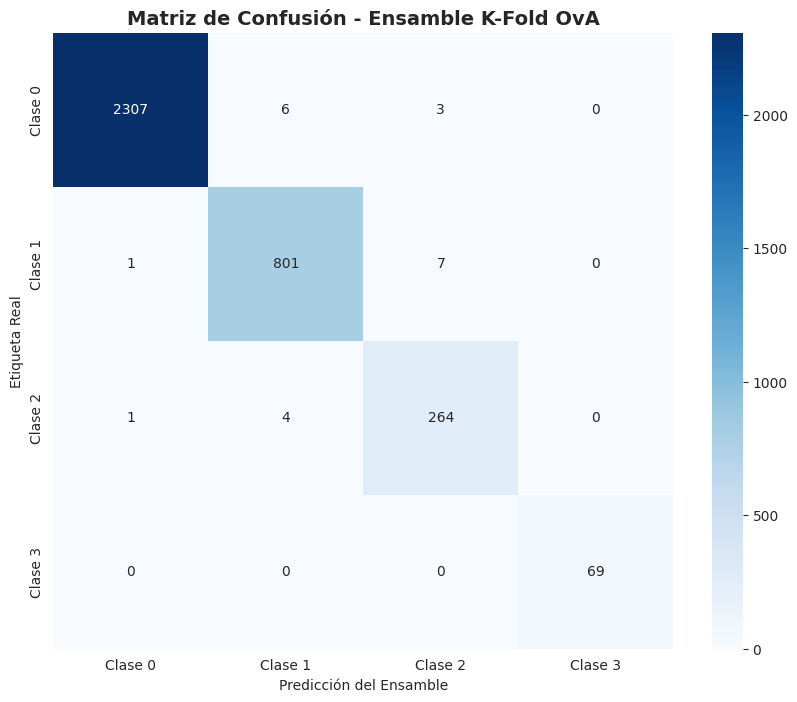

In [ ]:
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from transformers import AutoModelForSequenceClassification
from tqdm.auto import tqdm

def get_ensemble_predictions(df, tokenizer, models_path, n_folds=5, n_classes=4, batch_size=32):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    num_samples = len(df)

    # Matriz para acumular las probabilidades finales (muestras x clases)
    # Se inicializa en cero para ir sumando las probabilidades de cada fold
    final_probs = np.zeros((num_samples, n_classes))

    print(f"🚀 Iniciando inferencia con ensamble de {n_folds} pliegues...")

    for fold in range(n_folds):
        print(f"\n📂 Procesando Fold {fold + 1}...")

        # Matriz temporal para las probabilidades de este pliegue específico
        fold_probs = np.zeros((num_samples, n_classes))

        for class_id in range(n_classes):
            model_dir = f"{models_path}/class_{class_id}/fold_{fold}"
            print(f"  📥 Cargando experto Clase {class_id}...")

            # Cargar el modelo guardado para esta combinación de clase y pliegue
            model = AutoModelForSequenceClassification.from_pretrained(model_dir).to(device)
            model.eval()

            class_probs = []

            # Realizar predicciones en batches para optimizar memoria GPU
            for i in range(0, num_samples, batch_size):
                batch_texts = df['text'].iloc[i:i+batch_size].tolist()

                inputs = tokenizer(
                    batch_texts,
                    padding='max_length',
                    truncation=True,
                    max_length=128,
                    return_tensors='pt'
                ).to(device)

                with torch.no_grad():
                    outputs = model(**inputs)
                    # Aplicamos softmax para obtener probabilidades binarias (No es clase vs Sí es clase)
                    probs = torch.softmax(outputs.logits, dim=1)
                    # Nos quedamos con la probabilidad de la clase positiva (columna 1)
                    class_probs.extend(probs[:, 1].cpu().numpy())

            fold_probs[:, class_id] = np.array(class_probs)

            # Liberar memoria de GPU tras cada modelo
            del model
            torch.cuda.empty_cache()

        # Sumar las probabilidades del pliegue actual al acumulador total
        final_probs += fold_probs

    # Promediar las probabilidades dividiendo por el número de pliegues
    avg_probs = final_probs / n_folds
    # La predicción final es el índice de la clase con mayor probabilidad media
    final_predictions = np.argmax(avg_probs, axis=1)

    return final_predictions, avg_probs

# --- EJECUCIÓN DE LA VALIDACIÓN ---

# Realizar las predicciones sobre el dataset completo (df_train)
y_true = df_train['label'].values
y_pred, y_probs = get_ensemble_predictions(df_train, tokenizer, DRIVE_SAVE_PATH)

# --- VISUALIZACIÓN Y MÉTRICAS ---

print("\n" + "="*60)
print("📊 RESULTADOS FINALES DEL ENSAMBLE (K-FOLD OVA)")
print("="*60 + "\n")

# Reporte detallado de métricas
print(classification_report(y_true, y_pred, target_names=[f'Clase {i}' for i in range(4)]))

# Generar Matriz de Confusión
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f'Clase {i}' for i in range(4)],
            yticklabels=[f'Clase {i}' for i in range(4)])
plt.title('Matriz de Confusión - Ensamble K-Fold OvA', fontsize=14, fontweight='bold')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción del Ensamble')
plt.show()

---
## 🔮 Predicción en Test Set

In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 1. Cargar el dataset de test
df_test = pd.read_csv("Detoxis_test_kaggle.csv")
# Renombramos 'comment' a 'text' para que coincida con tus funciones previas
df_test = df_test.rename(columns={'comment': 'text'})

# 2. Configuración del Tokenizer (BETO)
MODEL_NAME = "dccuchile/bert-base-spanish-wwm-cased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# --- VERIFICACIÓN DE TOKENIZACIÓN ---
print("🔍 Verificando tokenización de un ejemplo:")
sample_text = df_test['text'].iloc[0]
tokens = tokenizer.tokenize(sample_text)
token_ids = tokenizer.encode(sample_text)

print(f"\nTexto original: {sample_text}")
print(f"Tokens: {tokens}")
print(f"IDs: {token_ids}")
print(f"¿Tokeniza bien?: {'Sí' if len(tokens) > 0 else 'No'}")

🔍 Verificando tokenización de un ejemplo:

Texto original: Les pagaran ellos de su bolsillo ,si no se llenara España de inmigrantes ilegales total estos los legalizaran
Tokens: ['Les', 'pagar', '##an', 'ellos', 'de', 'su', 'bolsillo', ',', 'si', 'no', 'se', 'llenar', '##a', 'España', 'de', 'inmigrantes', 'ilegales', 'total', 'estos', 'los', 'legal', '##izar', '##an']
IDs: [4, 3958, 3995, 1026, 2018, 1008, 1079, 13169, 1017, 1112, 1084, 1062, 16429, 30932, 3229, 1008, 11835, 13345, 2318, 2111, 1065, 6334, 6596, 1026, 5]
¿Tokeniza bien?: Sí


In [ ]:
def predict_test_set(df, tokenizer, save_path, n_folds=5, n_classes=4):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    num_samples = len(df)

    # Acumulador global de probabilidades (muestras x clases)
    final_probs = np.zeros((num_samples, n_classes))

    for fold in range(n_folds):
        print(f"\n--- Procesando Pliegue {fold + 1} ---")
        fold_probs = np.zeros((num_samples, n_classes))

        for class_id in range(n_classes):
            # Ruta donde guardaste los modelos en el paso anterior
            model_dir = f"{save_path}/class_{class_id}/fold_{fold}"
            model = AutoModelForSequenceClassification.from_pretrained(model_dir).to(device)
            model.eval()

            all_class_probs = []
            # Procesar en batches para no saturar la GPU
            batch_size = 32
            for i in range(0, num_samples, batch_size):
                texts = df['text'].iloc[i:i+batch_size].tolist()
                inputs = tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors='pt').to(device)

                with torch.no_grad():
                    logits = model(**inputs).logits
                    probs = torch.softmax(logits, dim=1)
                    # Probabilidad de la clase positiva (índice 1 en binario)
                    all_class_probs.extend(probs[:, 1].cpu().numpy())

            fold_probs[:, class_id] = np.array(all_class_probs)
            del model # Limpiar memoria
            torch.cuda.empty_cache()

        final_probs += fold_probs

    # Promediar y obtener clase final
    avg_probs = final_probs / n_folds
    predictions = np.argmax(avg_probs, axis=1)
    return predictions

# Ejecutar predicción
# DRIVE_SAVE_PATH debe ser el mismo que usaste al entrenar
predictions = predict_test_set(df_test, tokenizer, DRIVE_SAVE_PATH)

# Crear el archivo de sumisión
submission = pd.DataFrame({
    'id': df_test['id'],
    'label': predictions
})
submission.to_csv("submission_final.csv", index=False)
print("\n✅ Predicciones completadas y guardadas en submission_final.csv")


--- Procesando Pliegue 1 ---


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]


--- Procesando Pliegue 2 ---


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]


--- Procesando Pliegue 3 ---


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]


--- Procesando Pliegue 4 ---


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]


--- Procesando Pliegue 5 ---


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]


✅ Predicciones completadas y guardadas en submission_final.csv
